In [15]:
install.packages(c("xtable","hdm","randomForest","gbm","rpart.plot"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Machine Learning Estimators for Wage Prediction

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have only used basic linear regression for estimation
Now, we also consider penalized regression models and nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [16]:
load("/content/wage2015_subsample_inference.rdata")
dim(data)

[1] 5150   20

The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [17]:
Z <- subset(data,select=-c(lwage,wage)) # regressors
colnames(Z)

[1] "sex"  "shs"  "hsg"  "scl"  "clg"  "ad"   "mw"   "so"   "we"   "ne"  
[11] "exp1" "exp2" "exp3" "exp4" "occ"  "occ2" "ind"  "ind2"

The following figure shows the weekly wage distribution from the US survey data.

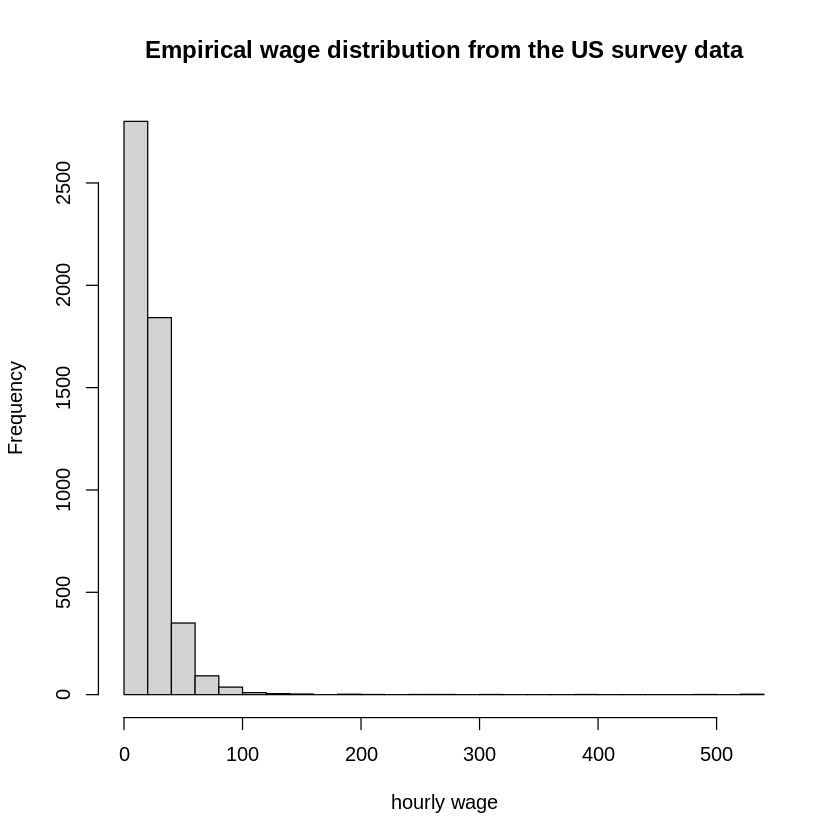

In [18]:
hist(data$wage, xlab= "hourly wage", main="Empirical wage distribution from the US survey data", breaks= 35)

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:

1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [19]:
set.seed(42)
training <- sample(nrow(data), nrow(data)*(3/4), replace=FALSE)

data_train <- data[training,]
data_test <- data[-training,]

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [20]:
X_basic <-  "sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
X_flex <- "sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"
formula_basic <- as.formula(paste("lwage", "~", X_basic))
formula_flex <- as.formula(paste("lwage", "~", X_flex))

model_X_basic_train <- model.matrix(formula_basic,data_train)
model_X_basic_test <- model.matrix(formula_basic,data_test)
p_basic <- dim(model_X_basic_train)[2]
model_X_flex_train <- model.matrix(formula_flex,data_train)
model_X_flex_test <- model.matrix(formula_flex,data_test)
p_flex <- dim(model_X_flex_train)[2]

In [21]:
Y_train <- data_train$lwage
Y_test <- data_test$lwage

In [22]:
p_basic
p_flex

[1] 52

[1] 246

As known from our first lab, the basic model consists of about $50$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression.

### OLS

**Exercise 1:** Fit the basic and flexible model to our training data by running an ols regression and compute the mean squared error on the test sample.

We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


**Exercise 2:** Run a lasso/post-lasso regression first and then compute the measures for the out-of-sample performance. Apply the package *hdm* and the function *rlasso* to rely on a theory-based choice of the penalty level $\lambda$ in the lasso regression.

In contrast to a theory-based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet.

**Exercise 3:** In this context, run a lasso, a ridge and a elastic net regression by adjusting the parameter *alpha* in the function *cv.glmnet*. Which model has the lowest mean squared error on the test sample?

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are apply regression trees, random forests and boosted trees to estimate the regression function $g(X)$. First, we load the relevant libraries.

In [23]:
library(randomForest)
library(rpart)
#library(nnet)
library(gbm)
library(rpart.plot)

and we illustrate the application of regression trees.

### Regression Trees

We fit a regression tree to the training data using the basic model. The parameter *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

**Exercise 4:** Play around with the tuning parameter *cp* and check how the structur of the regression tree changes. What does the parameter *cp* control?

cex 0.2   xlim c(0, 1)   ylim c(0, 1)


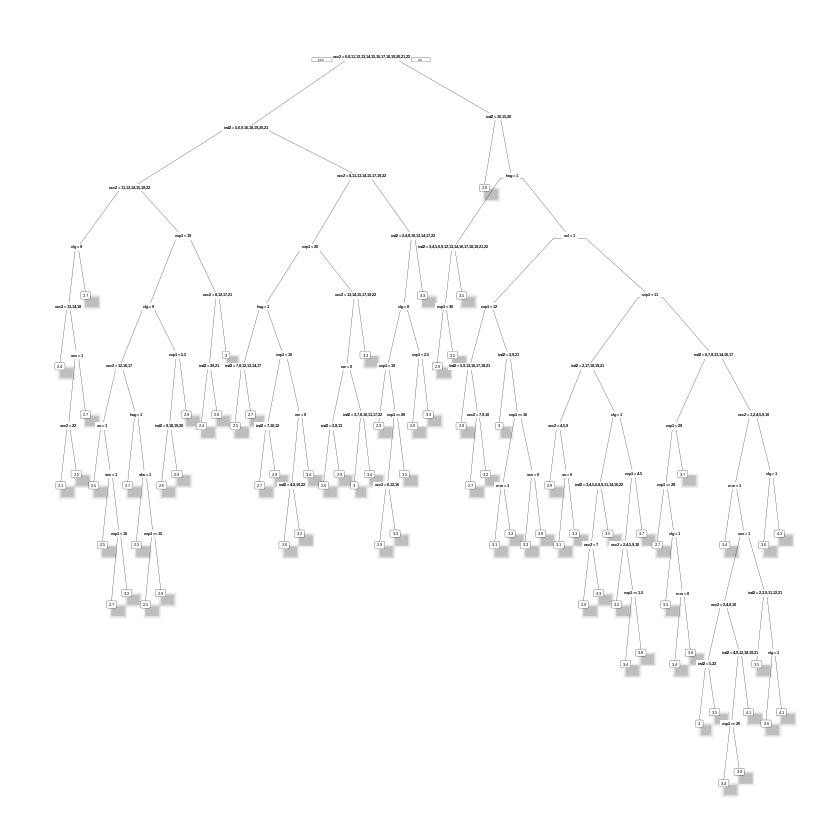

In [24]:
# fit the tree
fit.trees <- rpart(formula_basic, data_train,cp = 0.001)
prp(fit.trees,leaf.round=1, space=2, yspace=2,split.space=2,shadow.col = "gray",trace = 1) # plotting the tree

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

In [25]:
bestcp<- fit.trees$cptable[which.min(fit.trees$cptable[,"xerror"]),"CP"]
bestcp

[1] 0.002863859

Now, we can prune the tree and visualize the prediction rule.

cex 0.45   xlim c(0, 1)   ylim c(0, 1)


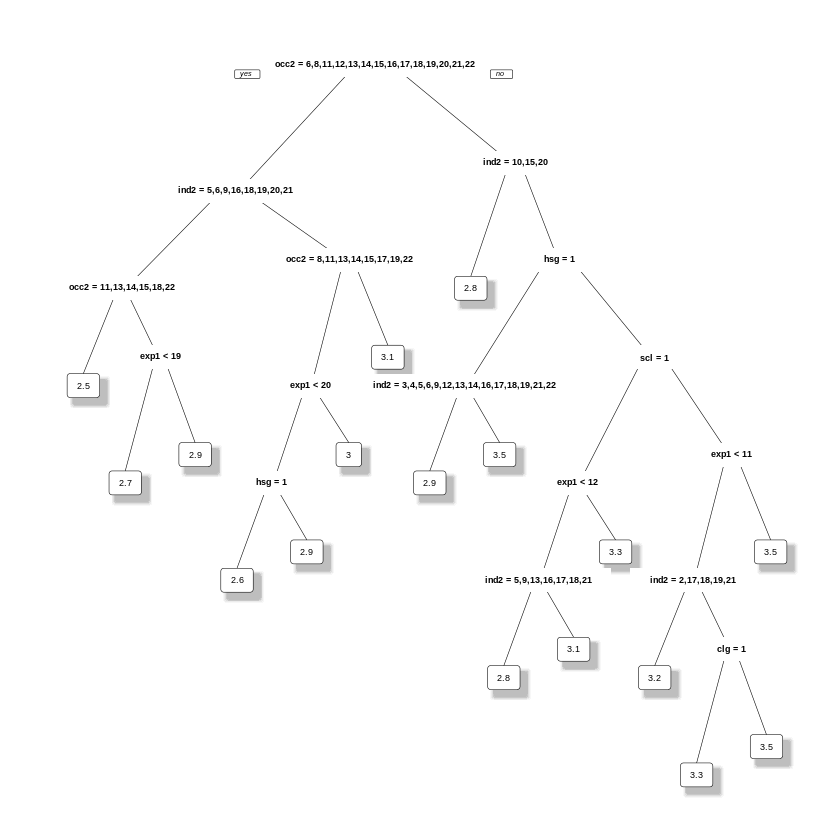

In [26]:
fit.prunedtree <- prune(fit.trees,cp=bestcp)
prp(fit.prunedtree,leaf.round=1, space=3, yspace=3, split.space=7, shadow.col = "gray",trace = 1,yesno=1)

In [27]:
?rpart.control

**Exercise 5:** Finally, calculate the mean-squared error  on the test sample to evaluate the out-of-sample performance of the pruned tree.

### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods: random forest and boosted trees.

In [28]:
## Applying the methods
# random forest
fit.rf       <- randomForest(formula_basic, ntree=2000, nodesize=5, data=data_train)
# for tuning: adjust input "mtry" to change the number of variables randomly sampled as candidates at each split

# boosting
fit.boost   <- gbm(formula_basic, data=data_train, distribution= "gaussian", bag.fraction = .5, interaction.depth=2, n.trees=1000, shrinkage=.01)
best.boost  <- gbm.perf(fit.boost, plot.it = FALSE) # cross-validation to determine when to stop

## Evaluating the methods
yhat.rf       <- predict(fit.rf, newdata=data_test) # prediction
yhat.boost    <- predict(fit.boost, newdata=data_test, n.trees=best.boost)

MSE.rf       = summary(lm((Y_test-yhat.rf)^2~1))$coef[1:2]
MSE.boost    = summary(lm((Y_test-yhat.boost)^2~1))$coef[1:2]
R2.rf  <- 1-MSE.rf[1]/var(Y_test)
R2.boost  <- 1-MSE.boost[1]/var(Y_test)

# printing R^2
cat("R^2 of the random forest and boosted trees:",R2.rf,R2.boost)


OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.



R^2 of the random forest and boosted trees: 0.2982853 0.2647682

**Exercise 6:** To conclude, summarize the results. What is the best model?

### Ensemble learning

**Exercise 7:** In the final step, build a prediction model by combining the strengths of the models we considered so far. This ensemble method is of the form
	$$ f(x) = \sum_{k=1}^K \alpha_k f_k(x) $$
where the $f_k$'s denote our prediction rules from the table above and the $\alpha_k$'s are the corresponding weights.